# Part 2 – A/B Test Analysis
## 1 – Objective of the Study
The goal of this A/B test is to evaluate the impact of an improved recommendation system on user behavior across three funnel stages: product page view (product_page), add to cart (product_cart), and purchase (purchase).
We expect at least a 10% uplift at each stage for the test group (B) relative to the control group (A) within 14 days after sign-up.
## 2 – Data Preparation and Validation
### 2.1 – Data Structure

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np

# Loading the datasets
# Marketing calendar
marketing = pd.read_csv('../data/samples/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('../data/samples/final_ab_new_users_upd_us.csv')
events = pd.read_csv('../data/samples/final_ab_events_upd_us.csv')
participants = pd.read_csv('../data/samples/final_ab_participants_upd_us.csv')


We loaded four core datasets: marketing, new users, events, and A/B participants. Below we quickly inspect their shapes and schemas.

In [ ]:
# Quick shape and schema checks
print(marketing.shape)
print(marketing.info())
print(marketing.head())

print(new_users.shape)
print(new_users.info())
print(new_users.head())

print(events.shape)
print(events.info())
print(events.head())

print(participants.shape)
print(participants.info())
print(participants.head())


(14, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes
None
                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
(58703, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entr

In [ ]:
# Missing values and duplicates
print(marketing.isna().sum())
print(new_users.isna().sum())
print(events.isna().sum())
print(participants.isna().sum())

print(marketing.duplicated().sum())
print(new_users.duplicated().sum())
print(events.duplicated().sum())
print(participants.duplicated().sum())


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
user_id       0
first_date    0
region        0
device        0
dtype: int64
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64
user_id    0
group      0
ab_test    0
dtype: int64
0
0
0
0


### 2.2 – Date conversion

In [ ]:
# Converting date columns to datetime for filtering and comparisons
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])

new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])


**What was done:**
We organized the data needed for the A/B analysis: loaded four datasets, checked structure, types, and the presence of nulls/duplicates. The only column with many nulls is details (expected, as it only applies to purchase events). We then converted all date/time fields to datetime to enable temporal filtering and joins.

**What we can conclude:**
The data is well structured and ready for analysis. With clean schemas and no critical anomalies, we can proceed to join events with test participants and build the conversion funnel without extra preprocessing.

## 3 – Exploration and Conversion Funnel
### 3.1 – Consistency check

In [ ]:
# Overlap between users in events and test participants
users_in_events        = events['user_id'].nunique()
users_in_participants  = participants['user_id'].nunique()
users_common           = events['user_id'].isin(participants['user_id']).sum()

print(f'Unique users in events: {users_in_events}')
print(f'Users in the test: {users_in_participants}')
print(f'Users appearing in both: {users_common}')



Unique users in events: 58703
Users in the test: 13638
Users appearing in both: 97123


### 3.2 – Basic funnel
#### 3.2.1 – Filter events to test participants

In [ ]:
events_filtered = events[events['user_id'].isin(participants['user_id'])]
events_merged = events_filtered.merge(participants, on='user_id')

#### 3.2.2 – One-count-per-user funnel by stage

In [ ]:
unique_events = events_merged.drop_duplicates(subset=['user_id', 'event_name'])

funnel = (
    unique_events.groupby(['group', 'event_name'])['user_id']
    .nunique()
    .unstack()
    .fillna(0)
    .astype(int)
)

funnel['conversion_cart'] = funnel['product_cart'] / funnel['product_page']
funnel['conversion_purchase'] = funnel['purchase'] / funnel['product_cart']
funnel['full_conversion'] = funnel['purchase'] / funnel['product_page']

print(funnel)


event_name  login  product_cart  product_page  purchase  conversion_cart  \
group                                                                      
A            7757          2453          5146      2654         0.476681   
B            5879          1941          3777      1909         0.513900   

event_name  conversion_purchase  full_conversion  
group                                             
A                      1.081940         0.515740  
B                      0.983514         0.505428  


#### 3.2.3 – Time-ordered funnel

In [ ]:
# Ensure timestamps are datetime
events_merged['event_time'] = pd.to_datetime(events_merged['event_dt'])

# First occurrence of each event per user
funnel_seq = (
    events_merged
    .pivot_table(index='user_id', columns='event_name', values='event_time', aggfunc='min')
)

funnel_seq = funnel_seq.reset_index()

funnel_seq = funnel_seq.merge(participants[['user_id', 'group']], on='user_id', how='left')

# Valid steps (allow equality to handle identical timestamps)
step_1 = ~funnel_seq['product_page'].isna()
step_2 = step_1 & (funnel_seq['product_cart'] >= funnel_seq['product_page'])
step_3 = step_2 & (funnel_seq['purchase'] >= funnel_seq['product_cart'])

# Counts per group and stage
funnel_counts = {
    'product_page': funnel_seq[step_1].groupby('group').size(),
    'product_cart': funnel_seq[step_2].groupby('group').size(),
    'purchase': funnel_seq[step_3].groupby('group').size()
}

# Final time-valid funnel with conversions
funnel_valid = pd.DataFrame(funnel_counts).fillna(0).astype(int)
funnel_valid['conversion_cart'] = funnel_valid['product_cart'] / funnel_valid['product_page']
funnel_valid['conversion_purchase'] = funnel_valid['purchase'] / funnel_valid['product_cart']
funnel_valid['full_conversion'] = funnel_valid['purchase'] / funnel_valid['product_page']

print(funnel_valid)


       product_page  product_cart  purchase  conversion_cart  \
group                                                          
A              5419          1221       156         0.225318   
B              4050           958       110         0.236543   

       conversion_purchase  full_conversion  
group                                        
A                 0.127764         0.028788  
B                 0.114823         0.027160  


#### 3.2.4 – Funnel visualization

In [ ]:
from plotly import graph_objects as go

# Group A
fig_a = go.Figure(go.Funnel(
    y=["View", "Add to Cart", "Purchase"],
    x=[
        funnel_valid.loc['A', 'product_page'],
        funnel_valid.loc['A', 'product_cart'],
        funnel_valid.loc['A', 'purchase']
    ],
    textinfo="value+percent initial",
    name="Group A"
))
fig_a.update_layout(title="Conversion Funnel — Group A")
fig_a.show()

# Group B
fig_b = go.Figure(go.Funnel(
    y=["View", "Add to Cart", "Purchase"],
    x=[
        funnel_valid.loc['B', 'product_page'],
        funnel_valid.loc['B', 'product_cart'],
        funnel_valid.loc['B', 'purchase']
    ],
    textinfo="value+percent initial",
    name="Group B"
))
fig_b.update_layout(title="Conversion Funnel — Group B")
fig_b.show()



### 3.3 - Event distribution per user

In [ ]:
# Events per user and group
events_per_user = events_merged.groupby(['user_id', 'group']).size().reset_index(name='n_events')

events_per_user.groupby('group')['n_events'].describe()


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,7874.0,7.45555,4.475159,1.0,4.0,6.0,9.0,40.0
B,6205.0,7.11249,4.246201,1.0,4.0,6.0,9.0,36.0


### 3.4 - Daily time series of events

<Axes: title={'center': 'Events per day by group'}, xlabel='date'>

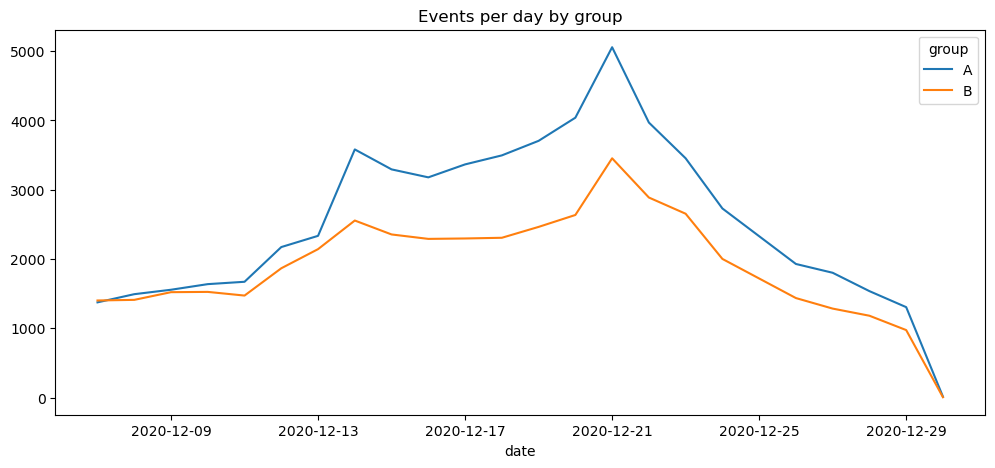

In [ ]:
# Count events per group by day
events_merged['date'] = events_merged['event_time'].dt.date
events_by_day = events_merged.groupby(['date', 'group']).size().unstack(fill_value=0)

events_by_day.plot(title='Events per day by group', figsize=(12,5))


### 3.5 – Interim conclusions

**What was done:**

Initially, we ensured that the analysis was restricted only to users who actually participated in the experiment by cross-referencing the event dataset with the A/B test participants table. With this subset, we built a simple conversion funnel based on unique user counts for product page views, add-to-cart events, and purchases. This allowed us to calculate conversion rates between each funnel stage for both groups.

Next, we implemented a more refined version of the funnel by considering the temporal sequence of events. To achieve this, we used the minimum timestamps for each type of event per user, enforcing a logical order of actions. At first, we applied strict (>) operators to ensure this progression, but the results were distorted because many events occurred at exactly the same second. We corrected this issue by replacing them with >= operators, which adjusted the funnel to better reflect real user behavior.

To complement the tabular analysis of the conversion funnel, we built funnel charts for Groups A and B based on the valid sequential data. These charts illustrate the number of users progressing through each stage: product page view, add to cart, and purchase.

Additionally, we investigated whether the number of events per user was distributed similarly between the groups. This analysis showed that means and standard deviations were very close for Groups A and B, suggesting an adequate behavioral equivalence between samples. Finally, we analyzed the temporal distribution of events. The daily events chart by group revealed that although Group A generated more events overall during the test, both groups followed very similar time curves, indicating that the experiment was carried out in a parallel and consistent way for both.

**What we can conclude:**

The construction of the unique-count funnel indicated that Group B had a slightly higher conversion rate to the cart, suggesting that the new recommendation system may be encouraging more mid-funnel interactions. However, Group A showed a slightly higher final conversion from product view to purchase. When validating the temporal sequence of events, these patterns remained consistent: Group B stands out in the add-to-cart stage, while Group A performs better in the final step.

The analysis of data particularities — especially regarding events with identical timestamps — was crucial to ensure that the time-based funnel did not incorrectly exclude valid user behavior. The evaluation of the number of events per user showed a very similar distribution between groups, without concerning asymmetries. The temporal analysis also revealed that both groups followed similar trajectories over time, reinforcing the integrity of the A/B test execution.

The charts confirm the previously identified patterns. Group B shows a slight percentage advantage in conversion from product view to cart (24% vs. 23%), while Group A demonstrates slightly better final conversion to purchase (3% in both groups, but with more absolute users). The sharp drop between add-to-cart and purchase in both groups highlights an important bottleneck in the last stage of the funnel that deserves further attention.

These findings indicate that the new recommendation system may drive greater initial engagement (more add-to-cart actions) but does not necessarily lead to more purchases. This reinforces the need to explore other stages of the user journey — such as checkout, offers, or payment methods — to improve the final conversion rate.





## 4 – Hypothesis Testing
In this stage, we evaluated whether the observed differences in conversion rates between Groups A and B at each step of the conversion funnel are statistically significant.
We used the valid temporal sequence funnel, which ensures the logical order of events:
product view → add to cart → purchase.

To do this, we applied one-tailed proportion Z-tests, with the alternative hypothesis that Group B (exposed to the new recommendation system) would perform better than Group A.

### 4.1 – Hypotheses Definition

For each stage of the funnel, we formulated the following hypotheses:

1. Product View → Add to Cart (product_cart)
- H₀ (null): The conversion rates of Groups A and B are equal.
- H₁ (alternative): The conversion rate of Group B is higher than that of Group A.
2. Add to Cart → Purchase (purchase)
- H₀ (null): The conversion rates of Groups A and B are equal.
- H₁ (alternative): The conversion rate of Group B is higher than that of Group A.

3. Product View → Purchase (full conversion)
- H₀ (null): The conversion rates of Groups A and B are equal.
- H₁ (alternative): The conversion rate of Group B is higher than that of Group A.

### 4.2 – Proportions Z-test helper

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

def test_proportions(success_a, total_a, success_b, total_b):
    # Order: B then A for a one-sided 'larger' test in favor of B
    count = np.array([success_b, success_a])
    nobs  = np.array([total_b,   total_a])
    stat, p_value = proportions_ztest(count, nobs, alternative='larger')
    return stat, p_value



### 4.3 – Apply tests by stage

We use the time-valid funnel (funnel_valid) so each step respects the event order.

#### 4.3.1 – Test: product_cart / product_page

In [ ]:
success_a = funnel_valid.loc['A', 'product_cart']
total_a = funnel_valid.loc['A', 'product_page']
success_b = funnel_valid.loc['B', 'product_cart']
total_b = funnel_valid.loc['B', 'product_page']

stat_cart, p_cart = test_proportions(success_a, total_a, success_b, total_b)
print(f"p-valor (view → cart): {p_cart:.4f}")


p-valor (view → cart): 0.0996


#### 4.3.2 – Test: purchase / product_cart

In [ ]:
success_a = funnel_valid.loc['A', 'purchase']
total_a = funnel_valid.loc['A', 'product_cart']
success_b = funnel_valid.loc['B', 'purchase']
total_b = funnel_valid.loc['B', 'product_cart']

stat_purchase, p_purchase = test_proportions(success_a, total_a, success_b, total_b)
print(f"p-valor (cart → purchase): {p_purchase:.4f}")


p-valor (cart → purchase): 0.8201


#### 4.3.3 – Test: purchase / product_page (full conversion)

In [ ]:
success_a = funnel_valid.loc['A', 'purchase']
total_a = funnel_valid.loc['A', 'product_page']
success_b = funnel_valid.loc['B', 'purchase']
total_b = funnel_valid.loc['B', 'product_page']

stat_full, p_full = test_proportions(success_a, total_a, success_b, total_b)
print(f"p-valor (view → purchase): {p_full:.4f}")



p-valor (view → purchase): 0.6823


### 4.4 – Interpretation of Results

**What was done:**
We ran one-sided z-tests for proportions at each funnel step using the time-valid sequence per user. For each step we compared success proportions across groups with the alternative that Group B > Group A.

Stages tested:
- View → Add to cart
- Add to cart → Purchase
- View → Purchase (full conversion)

**What we can conclude:**

- View → Cart: p = 0.0996 (> 0.05). No statistical evidence that B > A at this stage, even though B’s conversion is numerically higher.
- Cart → Purchase: p = 0.8201 (≫ 0.05). No difference between groups.
- View → Purchase: p = 0.6823 (> 0.05). No statistically significant impact on total conversion.

**Summary:**

The improved recommender did not produce statistically significant uplifts at any stage of the funnel. Visual differences (e.g., slightly higher add-to-cart for B) are not statistically robust.

Therefore, based on the available data and tests, we cannot justify adopting the new recommender solely on the grounds of a significant improvement in the conversion journey.


## 5 - Final Considerations

This report analyzed an A/B experiment for a new recommendation system. After validation, cleaning, and building a logically ordered conversion funnel, we assessed its impact on views, add-to-cart, and purchases.

Although Group B showed a slightly higher add-to-cart rate, statistical tests found no significant differences at any funnel stage. Thus, there is no strong evidence that the new system increases conversions, even if it may indicate slightly higher early engagement.

**Recommendations:**

- Investigate the cart → purchase drop-off in more depth.
- Explore improvements in downstream steps (checkout UX, pricing, payment methods) to raise final conversion.